In [1]:
import dask
import os
from satpy import Scene, MultiScene, find_files_and_readers
from pyresample.geometry import AreaDefinition
import yaml

# For masking
from shapely.geometry import mapping

# Imports for testing
from satpy.writers import to_image
from trollimage.colormap import spectral

In [119]:
# TODO Modularize
with open('../../config/satvis.yaml', 'r') as f:
    config = yaml.safe_load(f)

base_path = dir_dict['sentinel2']
sub_basin_shp = dir_dict['sub_basin_shp']


'C:\\Kodning\\Satvis\\data\\satvistest\\'

In [2]:
kvarnakershamn_test = AreaDefinition.from_area_of_interest(
    area_id="kvarnakershamn", 
    projection='epsg:3006', 
    shape=[2000, 2000], 
    center=[686119.299, 6345703.075], 
    resolution=[10, 10],
    )

In [4]:
scn_list = []

files = find_files_and_readers(base_dir=base_path, reader='msi_safe')
scn = Scene(filenames=files, reader='msi_safe')
scn_list.append(scn)
scn_list

In [5]:
mscn = MultiScene(scn_list)
mscn.load(['B03', 'B04'])
algotl_mscn = mscn.resample(kvarnakershamn_test)
algotl_scn = algotl_mscn.blend()

In [6]:
algotl_scn['kahru'] = algotl_scn['B03'] / algotl_scn['B04']

In [7]:
mins = .8
maxs = 1

img = to_image(algotl_scn['kahru'])
img.stretch('crude', min_stretch=[mins], max_stretch=[maxs])
spectral.set_range(mins, maxs)
# spectral.set_range(1, 2)
img.colorize(spectral)
img.show()

In [10]:
def basin_geodataframe():
    """Method to recreate the GeoDataFrame containing the Baltic Sea
    sub-basins according to SVAR_2016.
    """
    basin_mapping_SVAR = {
        1: 'Bottenviken',
        2: 'Norra Kvarken',
        3: 'Bottenhavet',
        4: 'Ålands hav',
        5: 'Skärgårdshavet',
        6: 'Finska viken',
        7: 'Norra Gotlandshavet',
        8: 'Västra Gotlandshavet',
        9: 'Östra Gotlandshavet',
        10: 'Rigabukten',
        11: 'Gdanskbukten',
        12: 'Bornholmshavet och Hanöbukten',
        13: 'Arkonahavet och Södra Öresund',
        14: 'Bälthavet',
        15: 'Öresund',
        16: 'Kattegatt',
        17: 'Skagerrak',
    }
    
    # TODO Rename sub_basin_shp to be easily identified
    # TODO add file as argument
    gdf_basin = gpd.read_file(sub_basin_shp)
    basin_geometries = gdf_basin[['BASIN_NR', 'geometry']]
    basin_data = basin_geometries.dissolve(
        by='BASIN_NR', as_index=True)
    basin_data['basin_name'] = [
        basin_mapping_SVAR[item] for item in basin_data.index]
    return basin_data

In [11]:
basin_gdf = basin_geodataframe()

In [ ]:
MSWEP_monthly2 = xarray.open_dataarray('D:\G3P\DATA\Models\MSWEP\MSWEP_monthly.nc4')
MSWEP_monthly2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
MSWEP_monthly2.rio.write_crs("epsg:4326", inplace=True)
Africa_Shape = geopandas.read_file('D:\G3P\DATA\Shapefile\Africa_SHP\Africa.shp', crs="epsg:4326")

clipped = MSWEP_monthly2.rio.clip(Africa_Shape.geometry.apply(mapping), Africa_Shape.crs, drop=False)

In [115]:
algotl_scn['kahru'].rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
algotl_scn['kahru'].rio.write_crs('epsg:3006', inplace=True)
algotl_scn['masked_kahru'] = algotl_scn['kahru'].rio.clip(basin_gdf.geometry.apply(mapping), basin_gdf.crs, drop=False)

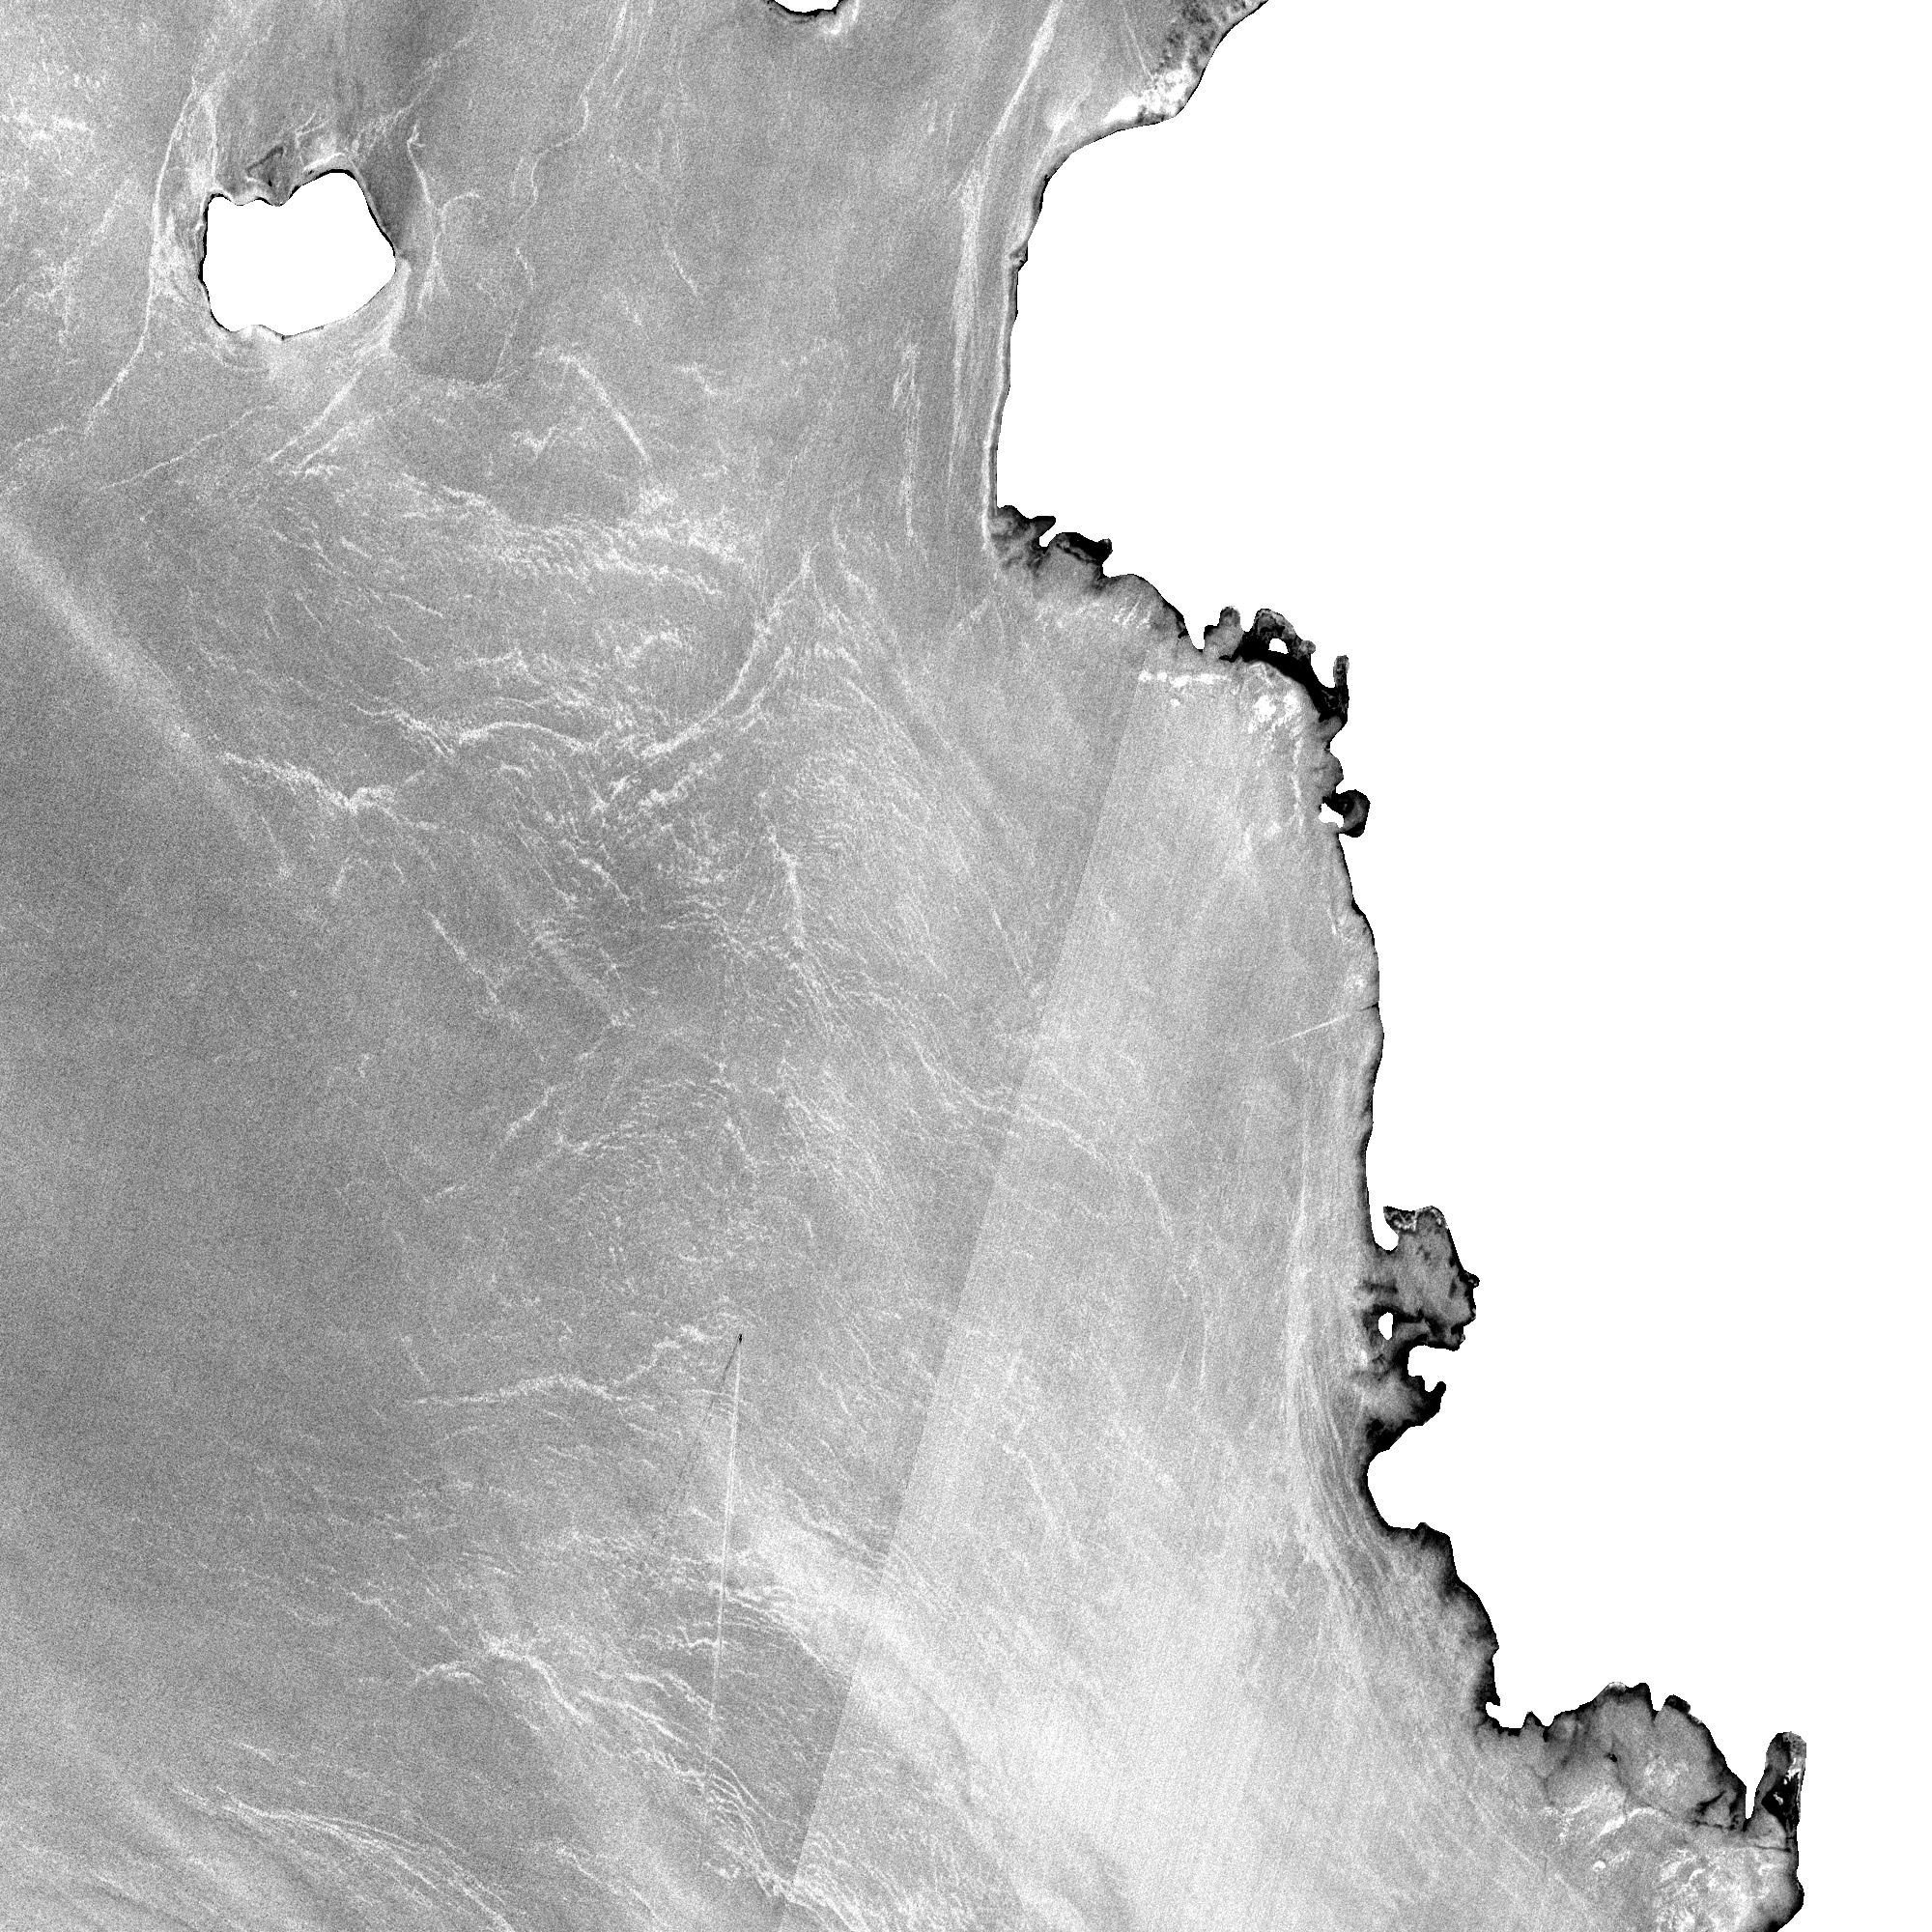

In [118]:
algotl_scn.show('masked_kahru')

In [84]:
# Get list of geometries for all features in vector file
geom = [shapes for shapes in basin_gdf.geometry]

In [98]:
algotl_gdf = algotl_scn['kahru'].to_dataframe(name='kahru')

In [104]:
rio.open(test_tiff)

<open DatasetReader name='C:/Arbetsmapp/Västerhavet/chl_nn_20240304_091614.tif' mode='r'>

In [107]:
rioxarray.open_rasterio(test_tiff)

<xarray.DataArray (band: 2, y: 1024, x: 1024)> Size: 2MB
[2097152 values with dtype=uint8]
Coordinates:
  * band         (band) int32 8B 1 2
  * x            (x) float64 8kB -4.004e+05 -3.994e+05 ... 6.216e+05 6.226e+05
  * y            (y) float64 8kB -2.923e+06 -2.924e+06 ... -3.945e+06 -3.946e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:     Area
    TIFFTAG_DATETIME:  2024:03:04 09:16:14
    scale_factor:      1.0
    add_offset:        0.0

In [103]:
algotl_gdf.transform

<bound method DataFrame.transform of                         band  spatial_ref  \
y           x                               
6355698.075 676124.299     1            0   
            676134.299     1            0   
            676144.299     1            0   
            676154.299     1            0   
            676164.299     1            0   
...                      ...          ...   
6335708.075 696074.299     1            0   
            696084.299     1            0   
            696094.299     1            0   
            696104.299     1            0   
            696114.299     1            0   

                                                                      crs  \
y           x                                                               
6355698.075 676124.299  PROJCRS["SWEREF99 TM",BASEGEOGCRS["SWEREF99",D...   
            676134.299  PROJCRS["SWEREF99 TM",BASEGEOGCRS["SWEREF99",D...   
            676144.299  PROJCRS["SWEREF99 TM",BASEGEOGCRS["SWEREF99",

In [102]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = rio.features.rasterize(geom,
                                out_shape = algotl_scn['kahru'].shape,
                                fill = 0,
                                out = None,
                                # transform = algotl_gdf.transform,
                                crs=algotl_scn['kahru'].crs,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca().invert_yaxis()

TypeError: rasterize() got an unexpected keyword argument 'crs'

In [77]:
# Define the extent and resolution of the output raster
xmin, ymin, xmax, ymax = got_gdf.total_bounds
# Define the resolution (in meters)
resolution = 10

# Calculate the number of columns and rows
ncols = int(round((xmax - xmin) / resolution))
nrows = int(round((ymax - ymin) / resolution))

# Define the output path and format
output_path = 'basin_mask.tif'
output_format = 'GTiff'

In [75]:
def rasterize_daily_shp(fid):
    gf = gpd.read_file(fid)
    save_path = fid.replace('.shp', '.tiff')
    with rio.open(save_path, 'w+') as out:
        out_arr = out.read(1)
        shapes = ((geom, value) for geom, value in list(zip(gf['geometry'], gf['basin_name'])))
        burned = rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        out.write_band(1, burned)

In [78]:
with rio.open(
    output_path,
    'w',
    driver=output_format,
    width=ncols,
    height=nrows,
    transform=rio.transform.from_bounds(xmin, ymin, xmax, ymax, ncols, nrows),
    crs=got_gdf.crs,
    count=1,
) as dst:
    rasterize(
        [(geom, value) for geom, value in zip(got_gdf.geometry, got_gdf['basin_name'])],
        out=rio.band(dst, 1),
        fill=0,
        all_touched=True,
    )

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U20'), dtype('<U20')) -> None

In [13]:
basin_dataarray = basin_gdf.geometry.to_xarray()

In [14]:
masked_scn = algotl_scn.load(['kahru'])

In [18]:
algotl_gdf = algotl_scn['kahru'].to_dataframe(name='kahru')

In [22]:
algotl_gdf.crs = "epsg:3006"

In [23]:
algotl_scn['masked_kahru'] = algotl_scn['kahru'].where(algotl_gdf.intersects(basin_gdf))

AttributeError: 'DataFrame' object has no attribute 'intersects'

In [ ]:
algotl_scn['kahru']

<xarray.DataArray (y: 2000, x: 2000)> Size: 16MB
dask.array<truediv, shape=(2000, 2000), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
    crs          object 8B PROJCRS["SWEREF99 TM",BASEGEOGCRS["SWEREF99",DATUM...
  * y            (y) float64 16kB 6.356e+06 6.356e+06 ... 6.336e+06 6.336e+06
  * x            (x) float64 16kB 6.761e+05 6.761e+05 ... 6.961e+05 6.961e+05
Attributes:
    name:       kahru2
    _satpy_id:  DataID(name='kahru2')

In [ ]:
algotl_scn['masked_kahru']

<xarray.DataArray (y: 2000, x: 2000)> Size: 16MB
dask.array<broadcast_to, shape=(2000, 2000), dtype=float32, chunksize=(2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
    crs          object 8B PROJCRS["SWEREF99 TM",BASEGEOGCRS["SWEREF99",DATUM...
  * y            (y) float64 16kB 6.356e+06 6.356e+06 ... 6.336e+06 6.336e+06
  * x            (x) float64 16kB 6.761e+05 6.761e+05 ... 6.961e+05 6.961e+05
Attributes:
    name:       masked_kahru2
    _satpy_id:  DataID(name='masked_kahru2')